In [139]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import numpy as np
import ast
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)

In [165]:
import matplotlib.colors as mcolors
import colorsys

# --- Styling defaults ---
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top']   = False

# Utility to lighten colors
def lighten_color(color, amount=1.1):
    try:
        c = mcolors.cnames[color]
    except KeyError:
        c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, min(1, l * amount), s)

colors = [lighten_color(i, 1.05) for i in ["#FF9999", "#99B3FF", "#FFCC99", "#9cdcb4"]]

In [166]:
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("Miles1999/interactive-COT-data",  split="train")

Resolving data files:   0%|          | 0/124 [00:00<?, ?it/s]

In [167]:
# adding the accuracy by error, 10 types in total, 9 errors and 1 correct explanation
# each error will be one column and the output for each cell will be [verificaion accuracy (binary), step identification accuracy(binary), time per question]
def make_error_stats(df):
    NA = [] # correct explanatin N/A
    CA = [] 
    CO = []
    CV = []
    CS = []
    MS =[]
    HA = []
    UC =[]
    OP =[]
    FC =[]
    for i in range(len(df)):
        for file in df["samples"][i]:
            error_type = file['file'].split("/")[-1].split("_")[-2]
            stats_list = []
            error_identification = 0
            step_identification = 0 
            time_elapse = 0
            if (file["label"] == 'correct' and file["humanAnswer"] == 'correct') or (file["label"] == 'wrong' and file["humanAnswer"] == 'incorrect'):
                error_identification = 1
                if file["actualWrongstep"] == file['userInputWrongStep']:
                    step_identification = 1
            time_elapse = file["elapsedSeconds"]
            stats_list = [error_identification, step_identification, time_elapse]
            match error_type:
                case "NA": 
                    NA.append(stats_list)
                case "CA":
                    CA.append(stats_list)
                case "CO":
                    CO.append(stats_list)
                case "CV":
                    CV.append(stats_list)
                case "CS":
                    CS.append(stats_list)
                case "MS":
                    MS.append(stats_list)
                case "HA":
                    HA.append(stats_list)
                case "UC":
                    UC.append(stats_list)
                case "OP":
                    OP.append(stats_list)
                case "FC":
                    FC.append(stats_list)
    return NA, CA, CO, CV, CS, MS, HA, UC, OP, FC

In [168]:
def make_button_click_stats(df):
    temp_df = df
    total_play = []
    total_stop =[]
    total_next =[]
    total_prev=[]
    for i in range(len(temp_df)):
        files = temp_df["samples"][i]
        play_b = 0
        stop_b = 0
        next_b = 0
        prev_b = 0
        for file in files:
            click_counts = file["clickCounts"]
            play_b+=click_counts["play"]
            stop_b+=click_counts["stop"]
            next_b+=click_counts["next"]
            prev_b+=click_counts["prev"]
        total_play.append(play_b/10)
        total_stop.append(stop_b/10)
        total_next.append(next_b/10)
        total_prev.append(prev_b/10)
    return total_play, total_stop, total_next, total_prev

In [169]:

# making the wrong step identification accuracy based on all 10 quesitons 
def make_wrong_step_identification_accuracy(df):
    acc_lst = []
    for i in range(len(df)):
        total_counter = 0
        indentified_counter = 0
        for file in df["samples"][i]:
            if file['humanAnswer'] == "incorrect":
                total_counter +=1
                if(file['actualWrongstep'] == file["userInputWrongStep"]):
                    indentified_counter+=1
        identification_rate = (indentified_counter/total_counter)*100
        acc_lst.append(identification_rate)
    return acc_lst

In [170]:
df_dataset = ds.to_pandas()
df_dataset['format'] = df_dataset['samples'].apply(
    lambda arr: arr[0]['file'].split('/')[3].split('_')[1] if len(arr) > 0 and 'file' in arr[0] else None
)
df_dataset['avgTimeCorrect'] = df_dataset['avgTimeCorrect'].astype(float)
df_dataset['avgTimeIncorrect'] = df_dataset['avgTimeIncorrect'].astype(float)
df_dataset["average_time"] = (df_dataset['avgTimeCorrect']+(df_dataset['avgTimeIncorrect']*9))/10
df_dataset["wrong_step_accuracy"] = make_wrong_step_identification_accuracy(df_dataset)
NA, CA, CO, CV, CS, MS, HA, UC, OP, FC = make_error_stats(df_dataset)
total_play, total_stop, total_next, total_prev = make_button_click_stats(df_dataset)
df_dataset["NA"] = NA
df_dataset["CA"] = CA
df_dataset["CO"] = CO
df_dataset["CV"] = CV
df_dataset["CS"] = CS
df_dataset["MS"] = MS
df_dataset["HA"] = HA
df_dataset["UC"] = UC
df_dataset["OP"] = OP
df_dataset["FC"] = FC
df_dataset["play_button_count"] = total_play
df_dataset["stop_button_count"] = total_stop
df_dataset["next_button_count"] = total_next
df_dataset["prev_button_count"] = total_prev


In [171]:

# 11, 61

#65, 95, 51
df_dataset[["timestamp","session_id","format","overallAccuracy","average_time"]]

,timestamp,session_id,format,overallAccuracy,average_time
0,2025-10-08T02:29:21.190312,00306102-26eb-4ea3-af0a-e59ad1d60c2e,cot,70,100.893
1,2025-10-07T16:01:55.697662,00a1ca28-601b-4a4f-968f-57c5021af83d,nat,50,75.842
2,2025-09-29T19:42:53.120914,00cdde91-a47f-4562-a98e-c7082c929e4e,coding,80,37.533
3,2025-10-09T19:15:11.894543,0305714f-7740-4ee3-98e7-4e53306019f2,coding,100,92.530
4,2025-09-29T18:29:01.376494,03158639-68a8-4faa-8a84-69c5f4322198,cot,70,81.180
5,2025-10-06T19:17:07.022464,03258ec9-d75f-45b8-888a-360001ad870b,coding,80,85.093
6,2025-09-29T18:23:26.631693,03d6ea61-d1bf-4442-9d2d-ecab9ad8ce82,cot,70,55.687
7,2025-10-06T19:11:41.233716,03ed8df9-cf5c-4a85-980a-8352f22cc3f2,nat,90,51.143
8,2025-10-06T19:14:36.290978,04d3adcb-f836-4e7c-9f5b-5b8cb26fc06d,coding,100,63.066
9,2025-10-08T00:19:13.210966,05a275d2-e4ab-49c7-869f-f8bb76a07771,coding,90,67.441


In [172]:
df_dataset.columns

Index(['overallAccuracy', 'correctItemAccuracy', 'incorrectItemAccuracy',
       'avgTimeCorrect', 'avgTimeIncorrect', 'samples', 'subjective_feedback',
       'timestamp', 'session_id', 'user_name', 'format', 'average_time',
       'wrong_step_accuracy', 'NA', 'CA', 'CO', 'CV', 'CS', 'MS', 'HA', 'UC',
       'OP', 'FC', 'play_button_count', 'stop_button_count',
       'next_button_count', 'prev_button_count'],
      dtype='object')

In [173]:
df_phd = pd.read_csv("phd_student_result.csv")
df_phd

,overallAccuracy,correctItemAccuracy,incorrectItemAccuracy,avgTimeCorrect,avgTimeIncorrect,samples,subjective_feedback,timestamp,session_id,user_name,...,CS,MS,HA,UC,OP,FC,play_button_count,stop_button_count,next_button_count,prev_button_count
0,100,100.0,100.00,84.72,45.52,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_graph_explanations/interactive_graph_right_NA_4.html', 'id': 'right_NA_4', 'label': 'correct', 'humanAnswer': 'correct', 'actu...",NaN,2025-09-26T15:57:15.779892,1d389cb7-e7bc-439b-a567-654f510d7b55,anonymous,...,"[1, 1, 57.056]","[1, 1, 46.814]","[1, 1, 59.897]","[1, 1, 23.208]","[1, 1, 34.126]","[1, 1, 32.166]",0.0,0.0,1.1,0.0
1,90,100.0,88.89,2.98,46.56,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/traditional_cot_explanations/traditional_cot_right_NA_5.html', 'id': 'right_NA_5', 'label': 'correct', 'humanAnswer': 'correct', 'actualWr...",NaN,2025-09-26T15:59:04.943697,40a272e0-04ad-4a08-970e-a285131da2c3,anonymous,...,"[1, 0, 38.659]","[1, 1, 43.322]","[1, 1, 33.413]","[1, 1, 59.748]","[1, 1, 23.412]","[1, 0, 53.851]",0.0,0.0,0.0,0.0
2,100,100.0,100.00,145.60,48.36,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_graph_explanations/interactive_graph_right_NA_3.html', 'id': 'right_NA_3', 'label': 'correct', 'humanAnswer': 'correct', 'actu...",NaN,2025-09-26T16:07:12.966044,6e4b8878-6592-4c30-a0bd-626363bb9609,anonymous,...,"[1, 0, 61.553]","[1, 1, 131.337]","[1, 1, 86.098]","[1, 1, 89.468]","[1, 1, 63.353]","[1, 1, 75.702]",0.0,0.0,4.6,2.0
3,90,0.0,100.00,191.84,67.18,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_nat_lang_explanations/interactive_natural_lang_right_NA_4.html', 'id': 'right_NA_4', 'label': 'correct', 'humanAnswer': 'incor...",NaN,2025-09-26T16:09:32.882210,77a03ca8-5ada-49de-9b9d-a89f3b48a153,anonymous,...,"[1, 1, 65.715]","[1, 1, 88.003]","[1, 1, 88.553]","[1, 1, 21.579]","[1, 0, 54.397]","[1, 1, 21.579]",1.0,0.0,0.0,0.0
4,90,100.0,88.89,39.97,52.36,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_nat_lang_explanations/interactive_natural_lang_right_NA_6.html', 'id': 'right_NA_6', 'label': 'correct', 'humanAnswer': 'corre...",NaN,2025-09-26T15:57:20.268756,7820d8d3-8e67-405e-8436-807e8965b984,anonymous,...,"[1, 1, 36.083]","[0, 0, 18.115]","[1, 1, 80.535]","[1, 1, 30.799]","[1, 0, 39.182]","[1, 1, 72.949]",0.2,0.0,3.4,0.2
5,80,100.0,77.78,112.13,52.71,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_nat_lang_explanations/interactive_natural_lang_right_NA_7.html', 'id': 'right_NA_7', 'label': 'correct', 'humanAnswer': 'corre...",NaN,2025-09-26T16:12:29.300147,953f3145-b1bf-47e2-a468-db861911f5c5,anonymous,...,"[1, 1, 173.116]","[0, 0, 50.384]","[1, 1, 89.101]","[1, 0, 109.799]","[1, 0, 77.15]","[0, 0, 245.497]",1.1,0.0,0.0,0.5
6,60,100.0,44.45,68.24,53.66,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_coding_explanations/interactive_code_right_NA_3.html', 'id': 'right_NA_3', 'label': 'correct', 'humanAnswer': 'correct', 'actu...","One selection was wrong, I misclicked on the ""correct"" button but the answer was in fact in correct. I think it should the 7th one?",2025-09-26T15:59:15.548796,9980a41b-e910-4f3b-952b-84b9c9a1843f,anonymous,...,"[0, 0, 27.749]","[0, 0, 67.818]","[1, 1, 37.516]","[1, 1, 61.631]","[0, 0, 58.081]","[1, 1, 41.008]",0.3,0.2,3.5,0.0
7,70,0.0,77.78,120.95,74.58,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/traditional_cot_explanations/traditional_cot_right_NA_4.html', 'id': 'right_NA_4', 'label': 'correct', 'humanAnswer': 'incorrect', 'actual...",NaN,2025-09-26T16:02:07.208937,cc33f6b9-b2cb-4e69-aff3-e489709814f8,anonymous,...,"[1, 1, 123.959]","[0, 0, 53.169]","[1, 1, 55.242]","[1, 0, 45.612]","[1, 1, 124.212]","[1, 1, 34.906]",0.0,0.0,0.0,0.0


In [365]:
df_total = pd.concat([df_dataset, df_phd]).drop([11,61,65,95,51], axis = 0).reset_index(drop= True)


In [184]:
df_total

,overallAccuracy,correctItemAccuracy,incorrectItemAccuracy,avgTimeCorrect,avgTimeIncorrect,samples,subjective_feedback,timestamp,session_id,user_name,...,CS,MS,HA,UC,OP,FC,play_button_count,stop_button_count,next_button_count,prev_button_count
0,70,100.00,66.67,210.36,88.73,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/traditional_cot_explanations/traditional_cot_right_NA_5.html', 'id': 'right_NA_5', 'label': 'correct', 'humanAnswer': 'correct', 'actualWr...",,2025-10-08T02:29:21.190312,00306102-26eb-4ea3-af0a-e59ad1d60c2e,anonymous,...,"[0, 0, 87.466]","[0, 0, 76.235]","[1, 0, 214.731]","[1, 1, 29.918]","[1, 1, 86.163]","[1, 1, 29.182]",0.0,0.0,0.0,0.0
1,50,100.00,44.44,75.14,75.92,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_nat_lang_explanations/interactive_natural_lang_wrong_FC_36.html', 'id': 'wrong_FC_36', 'label': 'wrong', 'humanAnswer': 'corre...",,2025-10-07T16:01:55.697662,00a1ca28-601b-4a4f-968f-57c5021af83d,anonymous,...,"[1, 1, 103.118]","[1, 1, 98.305]","[1, 1, 109.389]","[0, 0, 54.431]","[1, 1, 110.675]","[0, 0, 24.434]",0.0,0.0,7.1,0.0
2,80,100.00,75.00,42.96,36.93,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_coding_explanations/interactive_code_right_NA_8.html', 'id': 'right_NA_8', 'label': 'correct', 'humanAnswer': 'correct', 'actu...",,2025-09-29T19:42:53.120914,00cdde91-a47f-4562-a98e-c7082c929e4e,anonymous,...,"[1, 0, 41.333]","[0, 0, 42.265]","[1, 1, 22.933]","[1, 1, 42.999]","[0, 0, 47.666]","[1, 1, 12.849]",4.8,0.1,0.0,0.0
3,100,100.00,100.00,136.00,87.70,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_coding_explanations/interactive_code_right_NA_3.html', 'id': 'right_NA_3', 'label': 'correct', 'humanAnswer': 'correct', 'actu...",,2025-10-09T19:15:11.894543,0305714f-7740-4ee3-98e7-4e53306019f2,anonymous,...,"[1, 1, 158.01]","[1, 1, 67.385]","[1, 1, 63.881]","[1, 1, 64.04]","[1, 1, 98.929]","[1, 1, 52.488]",0.0,0.0,4.1,0.0
4,70,100.00,77.78,82.53,81.03,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/traditional_cot_explanations/traditional_cot_right_NA_7.html', 'id': 'right_NA_7', 'label': 'correct', 'humanAnswer': 'correct', 'actualWr...",,2025-09-29T18:29:01.376494,03158639-68a8-4faa-8a84-69c5f4322198,anonymous,...,"[1, 0, 164.641]","[1, 1, 24.174]","[0, 0, 35.278]","[0, 0, 48.016]","[1, 1, 25.785]","[0, 0, 149.535]",0.0,0.0,0.0,0.0
5,80,100.00,75.00,56.77,88.24,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_coding_explanations/interactive_code_right_NA_16.html', 'id': 'right_NA_16', 'label': 'correct', 'humanAnswer': 'correct', 'ac...",,2025-10-06T19:17:07.022464,03258ec9-d75f-45b8-888a-360001ad870b,anonymous,...,"[0, 0, 113.101]","[0, 0, 49.727]","[1, 1, 95.089]","[1, 1, 79.837]","[1, 1, 80.751]","[1, 1, 76.195]",0.2,0.0,0.0,0.0
6,70,100.00,66.67,56.47,55.60,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/traditional_cot_explanations/traditional_cot_right_NA_4.html', 'id': 'right_NA_4', 'label': 'correct', 'humanAnswer': 'correct', 'actualWr...",,2025-09-29T18:23:26.631693,03d6ea61-d1bf-4442-9d2d-ecab9ad8ce82,anonymous,...,"[1, 1, 33.02]","[1, 0, 74.546]","[0, 0, 49.509]","[1, 1, 36.407]","[1, 0, 73.942]","[1, 0, 43.795]",0.0,0.0,0.0,0.0
7,90,100.00,88.89,22.64,54.31,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_nat_lang_explanations/interactive_natural_lang_right_NA_27.html', 'id': 'right_NA_27', 'label': 'correct', 'humanAnswer': 'cor...",,2025-10-06T19:11:41.233716,03ed8df9-cf5c-4a85-980a-8352f22cc3f2,anonymous,...,"[1, 1, 46.182]","[1, 1, 42.848]","[1, 1, 70.975]","[1, 1, 32.899]","[1, 1, 43.562]","[1, 1, 47.712]",0.0,0.0,3.7,0.0
8,100,100.00,100.00,83.01,60.85,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_coding_explanations/interactive_code_right_NA_27.html', 'id': 'right_NA_27', 'label': 'correct', 'humanAnswer': 'correct', 'ac...",,2025-10-06T19:14:36.290978,04d3adcb-f836-4e7c-9f5b-5b8cb26fc06d,anonymous,...,"[

In [185]:
summary = df_total['format'].value_counts()
summary

format
coding    34
nat       33
cot       31
graph     30
Name: count, dtype: int64

(array([18., 79., 30.,  1.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([  4.348 ,  40.1681,  75.9882, 111.8083, 147.6284, 183.4485,
        219.2686, 255.0887, 290.9088, 326.7289, 362.549 ]),
 <BarContainer object of 10 artists>)

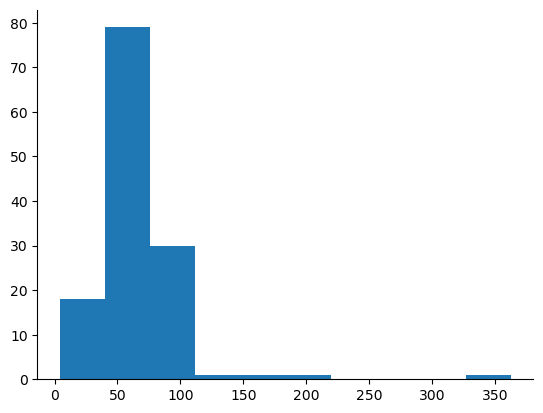

In [176]:
df_graph = df_total[df_total['format']=="average_time"]
plt.hist(df_total["average_time"])

In [177]:
#df_total[["session_id","wrong_step_accuracy","format"]]


In [178]:
# def get_button_stats(df):
#     temp_df = df
#     total_play = []
#     total_stop =[]
#     total_next =[]
#     total_prev=[]
#     for i in range(len(temp_df)):
#         files = temp_df["samples"][i]
#         play_b = 0
#         stop_b = 0
#         next_b = 0
#         prev_b = 0
#         data_list = ast.literal_eval(files.replace("}\n {", "}, {"))
#         for file in data_list:
#             click_counts = file["clickCounts"]
#             play_b+=click_counts["play"]
#             stop_b+=click_counts["stop"]
#             next_b+=click_counts["next"]
#             prev_b+=click_counts["prev"]
#         total_play.append(play_b/10)
#         total_stop.append(stop_b/10)
#         total_next.append(next_b/10)
#         total_prev.append(prev_b/10)
#     return total_play, total_stop, total_next, total_prev
        
# total_play, total_stop, total_next, total_prev = get_button_stats(df_phd)
# df_phd["play_button_count"] = total_play
# df_phd["stop_button_count"] = total_stop
# df_phd["next_button_count"] = total_next
# df_phd["prev_button_count"] = total_prev

# df_phd.to_csv("phd_student_result.csv",header= True, index = False)


In [179]:
def get_average_accuracy(df, format_type):
    temp_df = df[df["format"] == format_type]
    return temp_df['overallAccuracy'].mean()

print("graph: " + str(get_average_accuracy(df_total,"graph"))+" %")
print("cot: " + str(get_average_accuracy(df_total,"cot"))+" %")
print("code: " + str(get_average_accuracy(df_total,"coding"))+" %")
print("nl: " + str(get_average_accuracy(df_total,"nat"))+" %")

graph: 85.66666666666667 %
cot: 73.93939393939394 %
code: 83.23529411764706 %
nl: 80.88235294117646 %


In [180]:
def get_average_time(df, format_type):
    temp_df = df[df["format"] == format_type]
    return temp_df['average_time'].mean()


print("graph: " + str(get_average_time(df_total,"graph")) + " s")
print("cot: " + str(get_average_time(df_total,"cot"))+ " s")
print("code: " + str(get_average_time(df_total,"coding"))+ " s")
print("nl: " + str(get_average_time(df_total,"nat"))+ " s")

graph: 57.920899999999996 s
cot: 77.8619090909091 s
code: 63.195235294117644 s
nl: 63.71529411764706 s


In [181]:
def get_wrong_step_identification_accuracy(df, format_type):
    temp_df = df[df["format"] == format_type]
    return temp_df['wrong_step_accuracy'].mean()



print("graph: " + str(get_wrong_step_identification_accuracy(df_total,"graph")) + " %")
print("cot: " + str(get_wrong_step_identification_accuracy(df_total,"cot"))+ " %")
print("code: " + str(get_wrong_step_identification_accuracy(df_total,"coding"))+ " %")
print("nl: " + str(get_wrong_step_identification_accuracy(df_total,"nat"))+ " %")

graph: 85.2632275132275 %
cot: 66.47667147667147 %
code: 79.67903828197946 %
nl: 77.33076563958917 %


In [314]:
from scipy import stats
graph_step = df_total[df_total["format"]=="graph"]["wrong_step_accuracy"]
graph_time = df_total[df_total["format"]=="graph"]["average_time"]
graph_ver = df_total[df_total["format"]=="graph"]["overallAccuracy"]

cot_step = df_total[df_total["format"]=="cot"]["wrong_step_accuracy"]
cot_time = df_total[df_total["format"]=="cot"]["average_time"]
cot_ver = df_total[df_total["format"]=="cot"]["overallAccuracy"]

coding_step = df_total[df_total["format"]=="coding"]["wrong_step_accuracy"]
coding_time = df_total[df_total["format"]=="coding"]["average_time"]
coding_ver = df_total[df_total["format"]=="coding"]["overallAccuracy"]

nat_step = df_total[df_total["format"]=="nat"]["wrong_step_accuracy"]
nat_time = df_total[df_total["format"]=="nat"]["average_time"]
nat_ver = df_total[df_total["format"]=="nat"]["overallAccuracy"]


df_total = df_total.drop([11,61,65], axis = 0).reset_index (drop = True)
df_total

,overallAccuracy,correctItemAccuracy,incorrectItemAccuracy,avgTimeCorrect,avgTimeIncorrect,samples,subjective_feedback,timestamp,session_id,user_name,...,CS,MS,HA,UC,OP,FC,play_button_count,stop_button_count,next_button_count,prev_button_count
0,70,100.00,66.67,210.36,88.73,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/traditional_cot_explanations/traditional_cot_right_NA_5.html', 'id': 'right_NA_5', 'label': 'correct', 'humanAnswer': 'correct', 'actualWr...",,2025-10-08T02:29:21.190312,00306102-26eb-4ea3-af0a-e59ad1d60c2e,anonymous,...,"[0, 0, 87.466]","[0, 0, 76.235]","[1, 0, 214.731]","[1, 1, 29.918]","[1, 1, 86.163]","[1, 1, 29.182]",0.0,0.0,0.0,0.0
1,50,100.00,44.44,75.14,75.92,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_nat_lang_explanations/interactive_natural_lang_wrong_FC_36.html', 'id': 'wrong_FC_36', 'label': 'wrong', 'humanAnswer': 'corre...",,2025-10-07T16:01:55.697662,00a1ca28-601b-4a4f-968f-57c5021af83d,anonymous,...,"[1, 1, 103.118]","[1, 1, 98.305]","[1, 1, 109.389]","[0, 0, 54.431]","[1, 1, 110.675]","[0, 0, 24.434]",0.0,0.0,7.1,0.0
2,80,100.00,75.00,42.96,36.93,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_coding_explanations/interactive_code_right_NA_8.html', 'id': 'right_NA_8', 'label': 'correct', 'humanAnswer': 'correct', 'actu...",,2025-09-29T19:42:53.120914,00cdde91-a47f-4562-a98e-c7082c929e4e,anonymous,...,"[1, 0, 41.333]","[0, 0, 42.265]","[1, 1, 22.933]","[1, 1, 42.999]","[0, 0, 47.666]","[1, 1, 12.849]",4.8,0.1,0.0,0.0
3,100,100.00,100.00,136.00,87.70,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_coding_explanations/interactive_code_right_NA_3.html', 'id': 'right_NA_3', 'label': 'correct', 'humanAnswer': 'correct', 'actu...",,2025-10-09T19:15:11.894543,0305714f-7740-4ee3-98e7-4e53306019f2,anonymous,...,"[1, 1, 158.01]","[1, 1, 67.385]","[1, 1, 63.881]","[1, 1, 64.04]","[1, 1, 98.929]","[1, 1, 52.488]",0.0,0.0,4.1,0.0
4,70,100.00,77.78,82.53,81.03,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/traditional_cot_explanations/traditional_cot_right_NA_7.html', 'id': 'right_NA_7', 'label': 'correct', 'humanAnswer': 'correct', 'actualWr...",,2025-09-29T18:29:01.376494,03158639-68a8-4faa-8a84-69c5f4322198,anonymous,...,"[1, 0, 164.641]","[1, 1, 24.174]","[0, 0, 35.278]","[0, 0, 48.016]","[1, 1, 25.785]","[0, 0, 149.535]",0.0,0.0,0.0,0.0
5,80,100.00,75.00,56.77,88.24,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_coding_explanations/interactive_code_right_NA_16.html', 'id': 'right_NA_16', 'label': 'correct', 'humanAnswer': 'correct', 'ac...",,2025-10-06T19:17:07.022464,03258ec9-d75f-45b8-888a-360001ad870b,anonymous,...,"[0, 0, 113.101]","[0, 0, 49.727]","[1, 1, 95.089]","[1, 1, 79.837]","[1, 1, 80.751]","[1, 1, 76.195]",0.2,0.0,0.0,0.0
6,70,100.00,66.67,56.47,55.60,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/traditional_cot_explanations/traditional_cot_right_NA_4.html', 'id': 'right_NA_4', 'label': 'correct', 'humanAnswer': 'correct', 'actualWr...",,2025-09-29T18:23:26.631693,03d6ea61-d1bf-4442-9d2d-ecab9ad8ce82,anonymous,...,"[1, 1, 33.02]","[1, 0, 74.546]","[0, 0, 49.509]","[1, 1, 36.407]","[1, 0, 73.942]","[1, 0, 43.795]",0.0,0.0,0.0,0.0
7,90,100.00,88.89,22.64,54.31,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_nat_lang_explanations/interactive_natural_lang_right_NA_27.html', 'id': 'right_NA_27', 'label': 'correct', 'humanAnswer': 'cor...",,2025-10-06T19:11:41.233716,03ed8df9-cf5c-4a85-980a-8352f22cc3f2,anonymous,...,"[1, 1, 46.182]","[1, 1, 42.848]","[1, 1, 70.975]","[1, 1, 32.899]","[1, 1, 43.562]","[1, 1, 47.712]",0.0,0.0,3.7,0.0
8,100,100.00,100.00,83.01,60.85,"[{'file': 'interactive-llm-xai/evaluation/eval_interfaces/interactive_coding_explanations/interactive_code_right_NA_27.html', 'id': 'right_NA_27', 'label': 'correct', 'humanAnswer': 'correct', 'ac...",,2025-10-06T19:14:36.290978,04d3adcb-f836-4e7c-9f5b-5b8cb26fc06d,anonymous,...,"[

In [370]:
df_time = df_total[['NA', 'CA', 'CO', 'CV', 'CS', 'MS', 'HA', 'UC','OP', 'FC','format']]
import ast

def extract_third_value(x):
    # If it's a string, safely convert to list
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)
        except Exception:
            return None  # handle bad parsing
    # If it's already a list, proceed directly
    if isinstance(x, list) and len(x) >= 3 and x[0]==1:
        return x[2]
    return None  # fallback if missing or malformed

# Apply to all columns except 'format'
for col in df_time.columns[:-1]:
    df_time[col] = df_time[col].apply(extract_third_value)
df_time

df_melt_time = pd.melt(df_time, id_vars=['format'], value_vars=['NA', 'CA', 'CO', 'CV', 'CS', 'MS', 'HA', 'UC','OP', 'FC']).dropna(ignore_index= True)
igraph_df = df_melt_time[df_melt_time["format"]=="graph"]
icot_df = df_melt_time[df_melt_time["format"]=="nat"]
cot_df = df_melt_time[df_melt_time["format"]=="cot"]
ipot_df= df_melt_time[df_melt_time["format"]=="coding"]


/var/folders/mg/znm0ppk56vlcr_xph249z85m0000gn/T/ipykernel_86228/2786301468.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time[col] = df_time[col].apply(extract_third_value)


In [381]:
df_melt_time.to_csv("time_taken_each_question.csv",header =True, index = False)

In [376]:
print("mean for igraph ", igraph_df["value"].mean())
print("std for igraph ", igraph_df["value"].std())


mean for igraph  60.50885826771653
std for igraph  41.4677889506318


In [379]:
print("mean for cot ", cot_df["value"].mean())
print("std for cot ", cot_df["value"].std())

mean for cot  66.28572566371682
std for cot  40.95571917598545


In [378]:
print("mean for ipot ",ipot_df["value"].mean())
print("std for ipot ", ipot_df["value"].std())

mean for ipot  63.379699619771856
std for ipot  37.949341648397954


In [377]:
print("mean for icot ",icot_df["value"].mean())
print("std for icot ",icot_df["value"].std())

mean for icot  62.74813533834587
std for icot  35.807760972671204


In [342]:
plt.hist(graph_time, 
         alpha=0.5,
         label='igraph')

# plt.hist(cot_time,
#          alpha=0.5,
#         label='cot')
# plt.hist(coding_time,
#          alpha=0.5,
#          label='ipot')
# plt.hist(nat_time,
#          alpha=0.5,
#          label='icot')
plt.xlim(0,200)
# plt.legend(loc='upper right')
plt.title('iGraph')
plt.show()

NameError: name 'igraph_df' is not defined

In [136]:
from scipy import stats
statistic, p_value = stats.shapiro(nat_time)
print(p_value)

0.515338122844696


In [346]:


model = ols('value ~ C(format)', data=df_melt_time).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                 sum_sq      df         F    PR(>F)
C(format)  8.149909e+03     3.0  1.556686  0.198187
Residual   2.174445e+06  1246.0       NaN       NaN


In [369]:
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from itertools import combinations

print(kruskal(graph_ver, cot_ver, coding_ver, nat_ver))
methods = df_total["format"].unique()
print("Methods:", methods)
results = []
for m1, m2 in combinations(methods, 2):
    data1 = df_total.loc[df_total["format"] == m1, "wrong_step_accuracy"]
    data2 = df_total.loc[df_total["format"] == m2, "wrong_step_accuracy"]
    stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
    
    results.append({
        "Method 1": m1,
        "Method 2": m2,
        "U-stat": stat,
        "p-uncorrected": p
    })

results_df = pd.DataFrame(results)

# Apply Bonferroni correction
num_comparisons = len(results_df)
results_df["p-corrected"] = results_df["p-uncorrected"] * num_comparisons
results_df["p-corrected"] = results_df["p-corrected"].clip(upper=1.0)

# Flag significance
results_df["Significant"] = results_df["p-corrected"] < 0.05

# Calculate effect size (rank-biserial correlation)


results_df["Effect size (r)"] = [
    1 - (2 * u / (len(df_total[df_total["format"] == m1]) * len(df_total[df_total["format"] == m2])))
    for u, m1, m2 in zip(results_df["U-stat"], results_df["Method 1"], results_df["Method 2"])
]

print(results_df)

KruskalResult(statistic=15.091871930637897, pvalue=0.001739797533585034)
Methods: ['cot' 'nat' 'coding' 'graph']
  Method 1 Method 2  U-stat  p-uncorrected  p-corrected  Significant  \
0      cot      nat   333.0       0.016395     0.098368        False   
1      cot   coding   316.0       0.013194     0.079162        False   
2      cot    graph   162.0       0.000012     0.000069         True   
3      nat   coding   515.0       0.868672     1.000000        False   
4      nat    graph   335.0       0.026850     0.161099        False   
5   coding    graph   357.5       0.082262     0.493572        False   

   Effect size (r)  
0         0.348974  
1         0.362903  
2         0.651613  
3         0.024621  
4         0.323232  
5         0.255208  


In [364]:
# T test for verification
t_statistic, p_value = stats.ttest_ind(graph_ver, cot_ver )
print( t_statistic)
print(p_value)

t_statistic, p_value = stats.ttest_ind(coding_ver, cot_ver)
print(t_statistic)
print(p_value)

t_statistic, p_value = stats.ttest_ind(nat_ver, cot_ver )
print(t_statistic)
print(p_value)

## t test for wrong step verification
t_statistic, p_value = stats.ttest_ind(graph_step, cot_step)
print(t_statistic)
print(p_value)

t_statistic, p_value = stats.ttest_ind(coding_step, cot_step)
print(t_statistic)
print(p_value)

t_statistic, p_value = stats.ttest_ind(nat_step, cot_step)
print(t_statistic)
print(p_value)

## t test for time spent on each question
t_statistic, p_value = stats.ttest_ind(igraph_df["value"], cot_df["value"])
print("t_stats")
print(t_statistic)
print("p_value")
print(p_value)

t_statistic, p_value = stats.ttest_ind(icot_df["value"], cot_df["value"])
print("t_stats")
print(t_statistic)
print("p_value")
print(p_value)

t_statistic, p_value = stats.ttest_ind(ipot_df["value"], cot_df["value"])
print("t_stats")
print(t_statistic)
print("p_value")
print(p_value)

3.0238800008622717
0.003690690711116107
2.868040928827318
0.0056122413333699285
1.8581224570854733
0.06790093097773513
3.8020808097988996
0.00034246700524835687
2.7630267388681915
0.007498031075150607
2.7026977881507066
0.008862141354471357
t_stats
-1.2564503305097143
p_value
0.20959042995777288
t_stats
-1.1264048854004995
p_value
0.2605629250647814
t_stats
0.4953683450744551
p_value
0.6205590810162538


In [23]:
# output: verification accuracy, steps identification accuracy , time per question
def get_average_stats_by_error (df,format_type, error_type):
    temp_df = df[df["format"] == format_type]
    error_column = temp_df[error_type]
    total_explanation = 0
    total_verified = 0
    total_step_correct =  0
    total_time = 0
    for stats in error_column:
        if isinstance(stats, str):
            total_explanation+=1
            stripped_stats = stats.strip("[").strip("]").strip()
            splitted_stats = stripped_stats.split(",")
            splitted_stats[0] = int(splitted_stats[0] )
            splitted_stats[1] = int(splitted_stats[1] )
            splitted_stats[2] = float(splitted_stats[2] )
            total_verified+=splitted_stats[0]
            total_step_correct+=splitted_stats[1]
            total_time +=splitted_stats[2]
        else:
            total_explanation+=1
            total_verified+=stats[0]
            total_step_correct += stats[1]
            total_time += stats[2]
   
    return total_verified/total_explanation , total_step_correct/total_explanation, total_time/total_explanation
        

verified_NA_cot, step_NA_cot, time_NA_cot = get_average_stats_by_error(df_total, "cot", "NA")
verified_CA_cot, step_CA_cot, time_CA_cot = get_average_stats_by_error(df_total, "cot", "CA")
verified_CO_cot, step_CO_cot, time_CO_cot = get_average_stats_by_error(df_total, "cot", "CO")
verified_CV_cot, step_CV_cot, time_CV_cot = get_average_stats_by_error(df_total, "cot", "CV")
verified_CS_cot, step_CS_cot, time_CS_cot = get_average_stats_by_error(df_total, "cot", "CS")
verified_MS_cot, step_MS_cot, time_MS_cot = get_average_stats_by_error(df_total, "cot", "MS")
verified_HA_cot, step_HA_cot, time_HA_cot = get_average_stats_by_error(df_total, "cot", "HA")
verified_UC_cot, step_UC_cot, time_UC_cot = get_average_stats_by_error(df_total, "cot", "UC")
verified_OP_cot, step_OP_cot, time_OP_cot = get_average_stats_by_error(df_total, "cot", "OP")
verified_FC_cot, step_FC_cot, time_FC_cot = get_average_stats_by_error(df_total, "cot", "FC")

verified_NA_nat, step_NA_nat, time_NA_nat = get_average_stats_by_error(df_total, "nat", "NA")
verified_CA_nat, step_CA_nat, time_CA_nat = get_average_stats_by_error(df_total, "nat", "CA")
verified_CO_nat, step_CO_nat, time_CO_nat = get_average_stats_by_error(df_total, "nat", "CO")
verified_CV_nat, step_CV_nat, time_CV_nat = get_average_stats_by_error(df_total, "nat", "CV")
verified_CS_nat, step_CS_nat, time_CS_nat = get_average_stats_by_error(df_total, "nat", "CS")
verified_MS_nat, step_MS_nat, time_MS_nat = get_average_stats_by_error(df_total, "nat", "MS")
verified_HA_nat, step_HA_nat, time_HA_nat = get_average_stats_by_error(df_total, "nat", "HA")
verified_UC_nat, step_UC_nat, time_UC_nat = get_average_stats_by_error(df_total, "nat", "UC")
verified_OP_nat, step_OP_nat, time_OP_nat = get_average_stats_by_error(df_total, "nat", "OP")
verified_FC_nat, step_FC_nat, time_FC_nat = get_average_stats_by_error(df_total, "nat", "FC")

verified_NA_coding, step_NA_coding, time_NA_coding = get_average_stats_by_error(df_total, "coding", "NA")
verified_CA_coding, step_CA_coding, time_CA_coding = get_average_stats_by_error(df_total, "coding", "CA")
verified_CO_coding, step_CO_coding, time_CO_coding = get_average_stats_by_error(df_total, "coding", "CO")
verified_CV_coding, step_CV_coding, time_CV_coding = get_average_stats_by_error(df_total, "coding", "CV")
verified_CS_coding, step_CS_coding, time_CS_coding = get_average_stats_by_error(df_total, "coding", "CS")
verified_MS_coding, step_MS_coding, time_MS_coding = get_average_stats_by_error(df_total, "coding", "MS")
verified_HA_coding, step_HA_coding, time_HA_coding = get_average_stats_by_error(df_total, "coding", "HA")
verified_UC_coding, step_UC_coding, time_UC_coding = get_average_stats_by_error(df_total, "coding", "UC")
verified_OP_coding, step_OP_coding, time_OP_coding = get_average_stats_by_error(df_total, "coding", "OP")
verified_FC_coding, step_FC_coding, time_FC_coding = get_average_stats_by_error(df_total, "coding", "FC")

verified_NA_graph, step_NA_graph, time_NA_graph = get_average_stats_by_error(df_total, "graph", "NA")
verified_CA_graph, step_CA_graph, time_CA_graph = get_average_stats_by_error(df_total, "graph", "CA")
verified_CO_graph, step_CO_graph, time_CO_graph = get_average_stats_by_error(df_total, "graph", "CO")
verified_CV_graph, step_CV_graph, time_CV_graph = get_average_stats_by_error(df_total, "graph", "CV")
verified_CS_graph, step_CS_graph, time_CS_graph = get_average_stats_by_error(df_total, "graph", "CS")
verified_MS_graph, step_MS_graph, time_MS_graph = get_average_stats_by_error(df_total, "graph", "MS")
verified_HA_graph, step_HA_graph, time_HA_graph = get_average_stats_by_error(df_total, "graph", "HA")
verified_UC_graph, step_UC_graph, time_UC_graph = get_average_stats_by_error(df_total, "graph", "UC")
verified_OP_graph, step_OP_graph, time_OP_graph = get_average_stats_by_error(df_total, "graph", "OP")
verified_FC_graph, step_FC_graph, time_FC_graph = get_average_stats_by_error(df_total, "graph", "FC")



In [24]:
def get_button_stats(df,format_type):
    temp_df = df[df["format"]==format_type]
    avg_play_button_click = temp_df['play_button_count'].mean()
    avg_stop_button_click = temp_df["stop_button_count"].mean()
    avg_next_button_click = temp_df["next_button_count"].mean()
    avg_prev_button_click = temp_df["prev_button_count"].mean()
    return avg_play_button_click,avg_stop_button_click,avg_next_button_click,avg_prev_button_click



In [25]:
from scipy.stats import sem
def get_button_stats_se(df, format_type):
    temp_df = df[df["format"]==format_type]
    std_play_button_click = sem(temp_df['play_button_count'])
    std_stop_button_click =sem( temp_df["stop_button_count"])
    std_next_button_click =sem( temp_df["next_button_count"])
    std_prev_button_click =sem( temp_df["prev_button_count"])
    return std_play_button_click,std_stop_button_click,std_next_button_click,std_prev_button_click

In [58]:
df_survey = pd.read_csv("total_df_survey.csv")
df_survey

,timestamp,g1,g2,g3,g4,g5,format,d1,d2,d3,...,d7,d8,d9,d10,d11,d12,design1,design2,design3,design4
0,2025/10/06 12:21:01 AM AST,6,6,6,6,6,cot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025/10/06 2:44:50 PM AST,5,6,7,7,6,cot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025/10/06 3:09:14 PM AST,7,6,3,5,6,cot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025/10/06 3:10:11 PM AST,5,6,7,3,6,cot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025/10/06 3:11:06 PM AST,6,4,3,3,4,cot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2025/10/06 3:14:04 PM AST,7,5,7,7,6,cot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2025/10/06 3:14:07 PM AST,1,3,2,1,2,cot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2025/10/07 4:29:30 PM AST,1,2,2,1,1,cot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2025/10/07 4:32:51 PM AST,2,3,1,2,1,cot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2025/10/07 6:15:36 PM AST,4,3,5,4,4,cot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df_survey_graph = df_survey[df_survey["format"]=="igraph"]
df_survey_icode = df_survey[df_survey["format"]=="icoding"]
df_survey_icot = df_survey[df_survey["format"]=="icot"]
df_survey_cot = df_survey[df_survey["format"]=="cot"]
print(df_survey_graph["g1"].mean())
print(df_survey_icode["g1"].mean())
print(df_survey_icot["g1"].mean())
print(df_survey_cot["g1"].mean())

print(df_survey_graph["g2"].mean())
print(df_survey_icode["g2"].mean())
print(df_survey_icot["g2"].mean())
print(df_survey_cot["g2"].mean())

5.090909090909091
4.357142857142857
5.0
4.4
4.454545454545454
4.214285714285714
4.461538461538462
4.4


In [27]:
statistic, p_value = stats.shapiro(df_survey[df_survey["format"]=="icot"]["design4"])
print(p_value)

0.9910695552825928


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# ----------------------------------------------------------
#  CONFIGURATION
# ----------------------------------------------------------
fmt_map = {"cot": "CoT", "icot": "iCoT", "icoding": "iPoT", "igraph": "iGraph"}
likert_levels = [1, 2, 3, 4, 5, 6, 7]

# color palette: left = negative (RdPu), middle = neutral (gray), right = positive (Greens)
neg_colors = sns.color_palette("RdPu", 3)
neutral_color = (0.90, 0.90, 0.90)
pos_colors = sns.color_palette("Greens", 3)
legend_colors = list(neg_colors) + [neutral_color] + list(pos_colors)

# ----------------------------------------------------------
#  HELPER FUNCTIONS
# ----------------------------------------------------------
def tidy_for_format(df, fmt_key, mode="general"):
    """Return tidy dataframe and question order."""
    sub = df[df["format"] == fmt_key].copy()

    # general questions G1-G5
    g_cols = [f"g{i}" for i in range(1, 6)]
    g_melt = sub.melt(value_vars=g_cols, var_name="question", value_name="rating").dropna()
    g_melt["question"] = g_melt["question"].str.upper()

    if mode == "design":
        # only for interactive interfaces
        d_groups = {
            "D1": ["d1", "d2", "d3"],
            "D2": ["d4", "d5", "d6"],
            "D3": ["d7", "d8", "d9"],
            "D4": ["d10", "d11", "d12"],
        }
        d_parts = []
        for name, cols in d_groups.items():
            s = sub[cols].stack(dropna=True).reset_index(drop=True)
            d_parts.append(pd.DataFrame({"question": name, "rating": s}))
        tidy = pd.concat(d_parts, ignore_index=True)
        q_order = ["D1", "D2", "D3", "D4"]
    else:
        tidy = g_melt
        q_order = [f"G{i}" for i in range(1, 6)]

    tidy["rating"] = pd.to_numeric(tidy["rating"], errors="coerce").clip(1, 7)
    tidy = tidy.dropna(subset=["rating"])
    return tidy, q_order


def plot_breakdown_signed(df, fmt_key, outpath, mode="general"):
    tidy, q_order = tidy_for_format(df, fmt_key, mode=mode)

    # calculate % per rating
    tbl = tidy.pivot_table(index="question", columns="rating", values="rating", aggfunc="size", fill_value=0)
    pct = (tbl.div(tbl.sum(axis=1), axis=0) * 100).reindex(index=q_order).reindex(columns=likert_levels, fill_value=0)

    # Left (negative) and Right (neutral + positive)
    neg = pct[[1, 2, 3]]
    neu = pct[4]
    pos = pct[[5, 6, 7]]
    kept_share = (neu + pos.sum(axis=1))  # total non-negative share

    fig, ax = plt.subplots(figsize=(7, 4))
    y = pct.index.values

    # LEFT side: negative (1–3)
    left_neg = np.zeros(len(pct))
    for i, lvl in enumerate([3, 2, 1]):
        w = neg[lvl].values
        ax.barh(y, -w, left=-left_neg, color=neg_colors[i], edgecolor="none")
        left_neg += w

    # vertical 0 line
    ax.axvline(0, color="steelblue", lw=1.5, alpha=0.9)

    # RIGHT side: 4–7
    left_pos = np.zeros(len(pct))
    ax.barh(y, neu.values, left=left_pos, color=neutral_color, edgecolor="none")
    left_pos += neu.values
    for i, lvl in enumerate([5, 6, 7]):
        w = pos[lvl].values
        ax.barh(y, w, left=left_pos, color=pos_colors[i], edgecolor="none")
        left_pos += w

    # axis styling
    ax.set_xlim(-50, 100)
    ax.set_xticks([-50, -25, 0, 25, 50, 75, 100])
    ax.set_xticklabels([f"{t}%" for t in ax.get_xticks()], fontsize=14)
    ax.invert_yaxis()
    # ✅ set tick font size
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.2)     # thickness
        spine.set_color("black")     # color

    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    title = f"{fmt_map[fmt_key]}"
    ax.set_title(title, fontsize=20, fontweight="bold", pad=10)
    sns.despine(ax=ax, left=True, bottom=True)

    # right-side share labels
    for yi, val in enumerate(kept_share.values):
        ax.text(100.5, yi, f"{val:.0f}%", va="center", fontsize=20, fontweight="bold")

    # legend
    plt.tight_layout(pad=1.2)
    fig.savefig(outpath, bbox_inches="tight", pad_inches=0)
    plt.close(fig)


# ----------------------------------------------------------
#  MAIN EXECUTION
# ----------------------------------------------------------
df = pd.read_csv("total_df_survey.csv")

# ---- 4 General plots (G1–G5) ----
plot_breakdown_signed(df, "cot", "CoT_G1-G5.pdf", mode="general")
plot_breakdown_signed(df, "icot", "iCoT_G1-G5.pdf", mode="general")
plot_breakdown_signed(df, "icoding", "iCode_G1-G5.pdf", mode="general")
plot_breakdown_signed(df, "igraph", "iGraph_G1-G5.pdf", mode="general")

# ---- 3 Design plots (D1–D4) ----
plot_breakdown_signed(df, "icot", "iCoT_D1-D4.pdf", mode="design")
plot_breakdown_signed(df, "icoding", "iCode_D1-D4.pdf", mode="design")
plot_breakdown_signed(df, "igraph", "iGraph_D1-D4.pdf", mode="design")


/var/folders/mg/znm0ppk56vlcr_xph249z85m0000gn/T/ipykernel_86228/2152194451.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


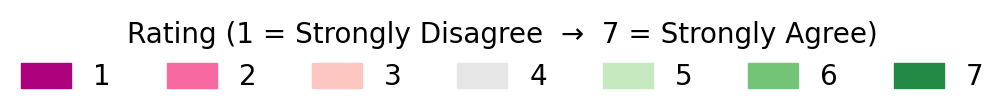

In [35]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Define same colors as your main plots
neg_colors = sns.color_palette("RdPu_r", 3)        # for 1–3 (negative, left side)
neutral_color = (0.90, 0.90, 0.90)               # 4 (neutral)
pos_colors = sns.color_palette("Greens", 3)      # for 5–7 (positive, right side)
legend_colors = list(neg_colors) + [neutral_color] + list(pos_colors)
labels = ["1", "2", "3", "4", "5", "6", "7"]

# Create dummy figure for legend
fig, ax = plt.subplots(figsize=(5, 1))
ax.axis("off")

# Build legend handles
handles = [Rectangle((0, 0), 1, 1, color=c) for c in legend_colors]

# Add legend at center
legend = ax.legend(
    handles,
    labels,
    title="Rating (1 = Strongly Disagree  →  7 = Strongly Agree)",
    loc="center",
    ncol=7,
    frameon=False,
    fontsize=20,
    title_fontsize=20,
    handlelength=1.8,
    handleheight=1.0,
)

# Adjust layout and save
plt.tight_layout()
plt.savefig("Likert_Legend.pdf", bbox_inches="tight", pad_inches=0)
plt.show()



[73.54838709677419, 80.60606060606061, 82.5, 85.66666666666667]


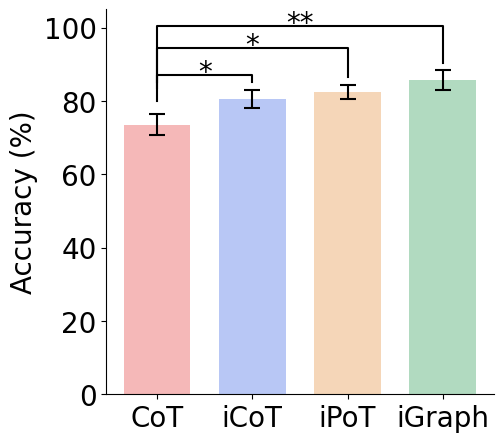

[64.73732258064517, 60.19712121212121, 59.50990625, 57.920899999999996]


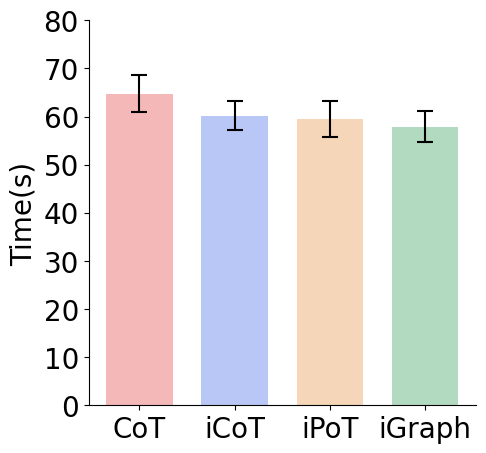

[66.60778289810548, 79.2953342953343, 80.13888888888889, 85.2632275132275]


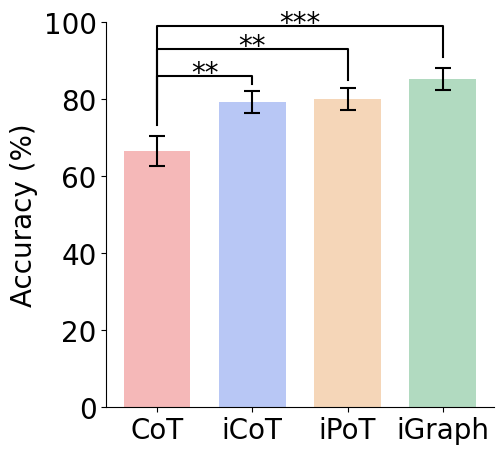

In [367]:
# Plot Accuracy with labels
accuracy = [get_average_accuracy(df_total,"cot"),get_average_accuracy(df_total,"nat"),get_average_accuracy(df_total,"coding"),get_average_accuracy(df_total,"graph")]
time =  [get_average_time(df_total,"cot"), get_average_time(df_total,"nat"), get_average_time(df_total,"coding"), get_average_time(df_total,"graph")]
identification_accuracy = [get_wrong_step_identification_accuracy(df_total,"cot"), get_wrong_step_identification_accuracy(df_total,"nat"), get_wrong_step_identification_accuracy(df_total,"coding"),get_wrong_step_identification_accuracy(df_total,"graph")]
colors = [lighten_color(i, 1.05) for i in ["#FF9999", "#99B3FF", "#FFCC99", "#9cdcb4"]]
order = ["cot","nat", "coding", "graph"]
display_labels = ["CoT", "iCoT", "iPoT", "iGraph"]

plt.figure(figsize=(5, 5))
ax = sns.barplot(
    data=df_total,
    x="format",       # column name in df_total
    y="overallAccuracy",     # column name with numeric values
    palette=colors,
    errorbar=None ,
    width = 0.7,
    order=order
)

# Get current x and y data for bars
bars = ax.patches
n = len(display_labels)
x_coords = [bar.get_x() + bar.get_width()/2  for bar in bars[:n]]

# Compute standard errors manually if not already
means = [df_total[df_total["format"] == f]["overallAccuracy"].mean() for f in order]
print(means)
ses = [df_total[df_total["format"] == f]["overallAccuracy"].sem() for f in order]

# Add capped error bars manually
for x, y, se in zip(x_coords, means, ses):
    plt.errorbar(
        x, y, yerr=se, fmt='none', ecolor='black', elinewidth=1.5, capsize=6, capthick=1.5
    )

def significance_bar(x1, x2, y, h1,h2, h3,text):
    ax.plot([x1, x1, x2, x2], [y-h1, y+h2, y+h2, y-h3], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y-3, text, ha='center', va='bottom', fontsize=20)
    
significance_bar(x_coords[0], x_coords[1], means[1]+ses[1]+4, means[1]-means[0], 0, 2, '*')
significance_bar(x_coords[0], x_coords[2], means[2]+ses[2]+10, means[2]-means[0] + 2, 0, 8, '*')
significance_bar(x_coords[0], x_coords[3], means[2]+ses[2]+16, means[3]-means[0] + 3, 0, 10, '**')

plt.xticks(ticks=range(len(order)), labels=display_labels, fontsize=20)                    # x-tick labels
plt.yticks(fontsize=20)
plt.ylabel("Accuracy (%)", fontsize=20)
plt.xlabel(None)
plt.ylim(0, 105)
plt.savefig("avg_verfication_accuracy_by_format.pdf", bbox_inches= "tight", pad_inches=0.1)

plt.show()


# Plot Time with labels
plt.figure(figsize=(5, 5))
ax = sns.barplot(
    data=df_total,
    x="format",       # column name in df_total
    y="average_time",     # column name with numeric values
    palette=colors,
    errorbar= None ,          # or "se", "95", etc. (can also set None to disable)
    width = 0.7,
    order=order
)

# Get current x and y data for bars
bars = ax.patches
n = len(display_labels)
x_coords = [bar.get_x() + bar.get_width()/2  for bar in bars[:n]]

# Compute standard errors manually if not already
means = [df_total[df_total["format"] == f]["average_time"].mean() for f in order]
print(means)
ses = [df_total[df_total["format"] == f]["average_time"].sem() for f in order]

# Add capped error bars manually
for x, y, se in zip(x_coords, means, ses):
    plt.errorbar(
        x, y, yerr=se, fmt='none', ecolor='black', elinewidth=1.5, capsize=6, capthick=1.5)   

plt.xticks(ticks=range(len(order)), labels=display_labels, fontsize=20)                    # x-tick labels
plt.yticks(fontsize=20)
plt.ylabel("Time(s)", fontsize=20)
plt.xlabel(None)
plt.ylim(0, 80)

plt.savefig("avg_time_by_format.pdf", bbox_inches= "tight", pad_inches=0.1)
plt.show()


# Plot Time with labels
plt.figure(figsize=(5, 5))
ax = sns.barplot(
    data=df_total,
    x="format",       # column name in df_total
    y="wrong_step_accuracy",     # column name with numeric values
    palette=colors,
    errorbar= None,
    width = 0.7,
    order = order
)

# Get current x and y data for bars
bars = ax.patches
n = len(display_labels)
x_coords = [bar.get_x() + bar.get_width()/2  for bar in bars[:n]]

# Compute standard errors manually if not already
means = [df_total[df_total["format"] == f]["wrong_step_accuracy"].mean() for f in order]
print(means)
ses = [df_total[df_total["format"] == f]["wrong_step_accuracy"].sem() for f in order]

# Add capped error bars manually
for x, y, se in zip(x_coords, means, ses):
    plt.errorbar(
        x, y, yerr=se, fmt='none', ecolor='black', elinewidth=1.5, capsize=6, capthick=1.5
    )
    
def significance_bar(x1, x2, y, h1,h2, h3,text):
    ax.plot([x1, x1, x2, x2], [y-h1, y+h2, y+h2, y-h3], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y-3, text, ha='center', va='bottom', fontsize=20)
    
significance_bar(x_coords[0], x_coords[1], means[1]+ses[1]+4, means[1]-means[0], 0, 2, '**')
significance_bar(x_coords[0], x_coords[2], means[2]+ses[2]+10, means[2]-means[0] + 2, 0, 8, '**')
significance_bar(x_coords[0], x_coords[3], means[2]+ses[2]+16, means[3]-means[0] + 3, 0, 8, '***')

plt.xticks(ticks=range(len(order)), labels=display_labels, fontsize=20)                    # x-tick labels
plt.yticks(fontsize=20)
plt.xlabel(None)
plt.ylabel("Accuracy (%)", fontsize=20)
plt.ylim(0, 100)
plt.savefig("avg_wrong_step_id_accuracy_by_format.pdf", bbox_inches= "tight", pad_inches=0.1)
plt.show()



In [ ]:
## Verification Accuracy for Each Error Category
categories = ["CoT", "ICoT", "ICode", "IGraph"]
measurements = ["N/A", "CA", "CO", "CV", "CS", "MS", "HA", "UC", "OP", "FC"]

# verification accuracy: shape = 9 groups × 4 categories
values = np.array([[verified_NA_cot,verified_NA_nat, verified_NA_coding,  verified_NA_graph],
                  [verified_CA_cot,verified_CA_nat,verified_CA_coding,  verified_CA_graph],
                  [ verified_CO_cot,verified_CO_nat,  verified_CO_coding,verified_CO_graph],
                  [verified_CV_cot,verified_CV_nat, verified_CV_coding,  verified_CV_graph],
                  [verified_CS_cot,verified_CS_nat, verified_CS_coding,  verified_CS_graph],
                  [verified_MS_cot,verified_MS_nat, verified_MS_coding,  verified_MS_graph],
                  [verified_HA_cot,verified_HA_nat, verified_HA_coding,  verified_HA_graph],
                  [verified_UC_cot,verified_UC_nat,  verified_UC_coding, verified_UC_graph],
                  [verified_OP_cot,verified_OP_nat, verified_OP_coding,  verified_OP_graph],
                  [verified_FC_cot,verified_FC_nat,  verified_FC_coding, verified_FC_graph]])

# Convert to long-form DataFrame
df_stats = pd.DataFrame(values, columns=categories)
df_stats["measurement"] = measurements
df_melted = df_stats.melt(id_vars="measurement", var_name="category", value_name="value")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_melted,
    x="measurement",     # 9 groups
    y="value",           # numeric values
    hue="category",      # 4 bars per group
    palette=colors,
    errorbar=None,       # disable default error bars
    dodge=True           # side-by-side grouping
)
plt.title("Verification Accuracy for Each Error Category")
plt.ylabel("Value")
plt.xlabel("Measurement")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("verification_accuracy_by_error_category.pdf")
plt.show()


In [ ]:
## Wrong Step Identification Accuracy for Each Error Category
categories = ["code", "cot", "nat", "graph"]
measurements = ["N/A", "CA", "CO", "CV", "CS", "MS", "HA", "UC", "OP", "FC"]

# wrong step idnetitifaction accuracy = 9 groups × 4 categories
values = np.array([[step_NA_coding, step_NA_cot,step_NA_nat, step_NA_graph],
                  [step_CA_coding, step_CA_cot,step_CA_nat, step_CA_graph],
                  [step_CO_coding, step_CO_cot,step_CO_nat, step_CO_graph],
                  [step_CV_coding, step_CV_cot,step_CV_nat, step_CV_graph],
                  [step_CS_coding, step_CS_cot,step_CS_nat, step_CS_graph],
                  [step_MS_coding, step_MS_cot,step_MS_nat, step_MS_graph],
                  [step_HA_coding, step_HA_cot,step_HA_nat, step_HA_graph],
                  [step_UC_coding, step_UC_cot,step_UC_nat, step_UC_graph],
                  [step_OP_coding, step_OP_cot,step_OP_nat, step_OP_graph],
                  [step_FC_coding, step_FC_cot,step_FC_nat, step_FC_graph]])

# Convert to long-form DataFrame
df_stats = pd.DataFrame(values, columns=categories)
df_stats["measurement"] = measurements
df_melted = df_stats.melt(id_vars="measurement", var_name="category", value_name="value")

import seaborn as sns
import matplotlib.pyplot as plt

palette = ["#bac9d7", "#e8d3bb", "#e2d7df", "#e0c1c0"]

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_melted,
    x="measurement",     # 9 groups
    y="value",           # numeric values
    hue="category",      # 4 bars per group
    palette=palette,
    errorbar=None,       # disable default error bars
    dodge=True           # side-by-side grouping
)
plt.title("Wrong Step Identification Accuracy for Each Error Category")
plt.ylabel("Value")
plt.xlabel("Measurement")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("wrong_step_identification_accuracy_by_error_category.pdf")
plt.show()


In [ ]:
# Average Time Spent for Each Error Category: 
categories = ["code", "cot", "nat", "graph"]
measurements = ["N/A", "CA", "CO", "CV", "CS", "MS", "HA", "UC", "OP", "FC"]

# Example data: shape = 9 groups × 4 categories
values = np.array([[time_NA_coding, time_NA_cot,time_NA_nat, time_NA_graph],
                  [time_CA_coding, time_CA_cot,time_CA_nat, time_CA_graph],
                  [time_CO_coding, time_CO_cot,time_CO_nat, time_CO_graph],
                  [time_CV_coding, time_CV_cot,time_CV_nat, time_CV_graph],
                  [time_CS_coding, time_CS_cot,time_CS_nat, time_CS_graph],
                  [time_MS_coding, time_MS_cot,time_MS_nat, time_MS_graph],
                  [time_HA_coding, time_HA_cot,time_HA_nat, time_HA_graph],
                  [time_UC_coding, time_UC_cot,time_UC_nat, time_UC_graph],
                  [time_OP_coding, time_OP_cot,time_OP_nat, time_OP_graph],
                  [time_FC_coding, time_FC_cot,time_FC_nat, time_FC_graph]])

# Convert to long-form DataFrame
df_stats = pd.DataFrame(values, columns=categories)
df_stats["measurement"] = measurements
df_melted = df_stats.melt(id_vars="measurement", var_name="category", value_name="value")

import seaborn as sns
import matplotlib.pyplot as plt

palette = ["#bac9d7", "#e8d3bb", "#e2d7df", "#e0c1c0"]

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_melted,
    x="measurement",     # 9 groups
    y="value",           # numeric values
    hue="category",      # 4 bars per group
    palette=palette,
    errorbar=None,       # disable default error bars
    dodge=True           # side-by-side grouping
)
plt.title("Average Time Spent for Each Error Category")
plt.ylabel("Value")
plt.xlabel("Measurement")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("average_time_spent_by_error_category.pdf")
plt.show()


In [ ]:
# Average click of button for each format Category: 
categories = ["iCode", "iCoT", "iGraph"]
measurements = ["play button", "stop button", "next button", "prev button"]
# average clicks
avg_play_button_click_graph,avg_stop_button_click_graph,avg_next_button_click_graph,avg_prev_button_click_graph = get_button_stats(df_total, "graph")
avg_play_button_click_nat,avg_stop_button_click_nat,avg_next_button_click_nat,avg_prev_button_click_nat = get_button_stats(df_total, "nat")
avg_play_button_click_coding,avg_stop_button_click_coding,avg_next_button_click_coding,avg_prev_button_click_coding = get_button_stats(df_total, "coding")
# std for clicks

std_play_button_click_graph,std_stop_button_click_graph,std_next_button_click_graph,std_prev_button_click_graph = get_button_stats_se(df_total, "graph")
std_play_button_click_nat,std_stop_button_click_nat,std_next_button_click_nat,std_prev_button_click_nat = get_button_stats_se(df_total, "nat")
std_play_button_click_coding,std_stop_button_click_coding,std_next_button_click_coding,std_prev_button_click_coding = get_button_stats_se(df_total, "coding")

# Example data: shape = 4 groups × 3 categories
values = np.array([[avg_play_button_click_coding, avg_play_button_click_nat, avg_play_button_click_graph],
                  [avg_stop_button_click_coding, avg_stop_button_click_nat, avg_stop_button_click_graph],
                  [avg_next_button_click_coding, avg_next_button_click_nat, avg_next_button_click_graph],
                  [avg_prev_button_click_coding, avg_prev_button_click_nat, avg_prev_button_click_graph]])

errors = np.array([[std_play_button_click_coding, std_play_button_click_nat, std_play_button_click_graph],
                  [std_stop_button_click_coding, std_stop_button_click_nat, std_stop_button_click_graph],
                  [std_next_button_click_coding, std_next_button_click_nat, std_next_button_click_graph],
                  [std_prev_button_click_coding, std_prev_button_click_nat, std_prev_button_click_graph]])

# Convert to long-form DataFrame
df_stats = pd.DataFrame(values, columns=categories)
df_stats["measurement"] = measurements
df_melted = df_stats.melt(id_vars="measurement", var_name="category", value_name="value")

# Melt errors in the same order as df_melted
df_err = pd.DataFrame(errors, columns=categories)
df_err["measurement"] = measurements
df_err_melted = df_err.melt(id_vars="measurement", var_name="category", value_name="err")

palette = [ "#99B3FF", "#FFCC99", "#9cdcb4"]

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_melted,
    x="measurement",     # 9 groups
    y="value",           # numeric values
    hue="category",      # 4 bars per group
    palette=palette,
    errorbar=None ,     # disable default error bars
    dodge=True           # side-by-side grouping
)

# Number of measurement groups
measurements_unique = df_melted["measurement"].unique()
categories_unique = df_melted["category"].unique()

# Width offset for each bar in a group
group_width = 0.8          # total width of a group
bar_width = group_width / len(categories_unique)

for i, measurement in enumerate(measurements_unique):
    for j, category in enumerate(categories_unique):
        # Find the mean and error
        mean_val = df_melted[(df_melted.measurement == measurement) & 
                             (df_melted.category == category)]["value"].values[0]
        err_val = df_err_melted[(df_err_melted.measurement == measurement) & 
                                (df_err_melted.category == category)]["err"].values[0]

        # Compute bar center x coordinate
        x_pos = i - group_width/2 + (j+0.5)*bar_width

        # Draw error bar
        plt.errorbar(
            x=x_pos,
            y=mean_val,
            yerr=err_val,
            fmt='none',
            ecolor='black',
            elinewidth=1.2,
            capsize=0,
            capthick=0,
            zorder=10
        )
        plt.text(
            x_pos + 0.08,
            mean_val + 0.05,      # small vertical offset
            f"{mean_val:.2f}",    # format label text
            ha='center',
            va='bottom',
            fontsize=9
        )




plt.ylabel("Number of Clicks")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.xlabel(None)
plt.savefig("average_button_click_per_format_category.pdf",bbox_inches= "tight", pad_inches=0.1)
plt.show()

In [ ]:
# add behavior plot where the students clicked on different buttons
# add the error bar. 
# add the accuracy for each error type 
# accuracy for selecting the wrong steps
# across the study, summarize the stats for the incorrect and correct questions. (button click, time spent)
# repeat the same for corrrect incorrect step questions.
# randomize the questions 
# add the post survey questions. 